# Preprocessing & Visualization

## Introduction
Single-cell RNA-seq datasets have two important properties that one should have in mind when performing an analysis. Firstly, scRNA-seq are drop-out meaning that there is an excessive number of zeros in the data due to limiting mRNA. Secondly, the potential for correcting the data and performing quality control might be limited as the data may be confounded with biology. It is therefore crucial to select preprocessing methods that are suited to the underlying data without overcorrecting or removing biological effects.

This chapter will guide you through the steps of data preprocessing and visualization. A mentioned earlier, the set of tools for the analysis of single-cell RNA-sequencing data is evolving fast due to new sequencing technologies and a growing number of captured cells, measured genes and identified cell populations. (CITE 1000 Tools Zappia) Many of these tools are dedicated to preprocessing which aims to address the following analysis steps: doublet detection, quality control, normalization, feature selection, and dimensionality reduction. Preprocessing is a crucial step in scRNA-seq data analyis. The tools selected throughout this chapter can heavily affect downstream analysis and interpretation of the data. For example, if you filter out too many cells during quality control, you might lose rare cell subpopulations and miss insight into interesting cell biology. Whereas if you are too permissive, you might have a hard time annotating your cells if you did not exclude poor quality cells in your preprocessing pipeline. Therefore, it is important to select tools that provide a best practice and that proved to outperform other with respect to downstream tasks. In many cases, you will still have to re-assess your preprocessing analysis and change, for example, your filtering strategy. This is natural and the daily struggle of every computational biologist. 

The starting point of this notebook are raw sequencing data generated by sequencing machines. The data was processed and aligned to obtain matrices of molecular counts, so called count matrices, or read counts (read matrices). The difference between count and read matrices depends on whether unique molecular identifiers (UMIs) were included in the single-cell library construction protocol. Read and count matrices have the dimension number of barcodes x number of transcripts. It is important to note that the term "barcode" is used here instead of "cell" as a barcode might wrongly have tagged multiple cells (doublet) or might have not tagged any cell (empty droplet/well). We will elaborate more on this in the next section "Doublet detection". 

### Dataset
We first load the dataset with scanpy which can be downloaded from figshare (ADD LINK). We use a human bone marrow dataset from .... CITE. 

In [1]:
import scanpy as sc
sc.settings.verbosity = 3
sc.settings.set_figure_params(
    dpi=80, facecolor='white', 
    #color_map="YlGnBu", 
    frameon=False
)

In [2]:
sc.__version__

'1.9.1'

In [3]:
# switch to figshare afterwards
adata = sc.read_10x_h5('s4d8/filtered_feature_bc_matrix.h5')

reading s4d8/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:03)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


After reading the data, scanpy displays a warning that not all variable names are unique. We execute the proposed function and have a look into our AnnData object.

In [4]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

The dataset has the shape `n_obs` 16,934 x `n_vars` 36,601. This translates into barcodes x number of transcripts. We additionally inspect further information in `.var` in terms of gene_ids (Ensembl Id), feature_types and genome. 

## Quality Control

### Removal of ambient RNA



In [5]:
import anndata2ri
import logging
from scipy.sparse import issparse

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [6]:
%%R
library(SoupX)

In [7]:
adata_raw = sc.read_10x_h5('s4d8/raw_feature_bc_matrix.h5')

reading s4d8/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:04)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [8]:
adata_raw.var_names_make_unique()
adata_raw

AnnData object with n_obs × n_vars = 692666 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [9]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added = "soupx_groups")

#Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

del adata_pp

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:37)
computing neighbors
    using 'X_pca' with n_pcs = 50


LoweringError: Failed in nopython mode pipeline (step: native lowering)
Invalid store of i64 to i32 in <numba.core.datamodel.models.RangeModel object at 0x7f9001ecca90> (trying to write member #1)

File "../../../../../../opt/miniconda3/envs/bestprac2_dataprep/lib/python3.8/site-packages/umap/layouts.py", line 53:
def rdist(x, y):
    <source elided>
    dim = x.shape[0]
    for i in range(dim):
    ^

During: lowering "$20call_function.7 = call $16load_global.5(dim, func=$16load_global.5, args=[Var(dim, layouts.py:52)], kws=(), vararg=None, target=None)" at /Users/anna.schaar/opt/miniconda3/envs/bestprac2_dataprep/lib/python3.8/site-packages/umap/layouts.py (53)

In [ ]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T
data_tod = adata_raw.X.T

In [ ]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out

rownames(data) = genes
colnames(data) = cells
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

## Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
sc = setClusters(sc, soupx_groups)

sc  = autoEstCont(sc)
out = adjustCounts(sc, roundToInt = TRUE)

In [ ]:
adata.layers['counts'] = adata.X
adata.layers['soupX_counts'] = out.T
adata.X = adata.layers['soupX_counts']

### Filtering low quality reads

The dataset might contain low-quality reads which are filtered by cell quality control (QC). Cell QC is typically performed on the following three QC covariates: the number of counts per barcode (count depth), number of genes per barcode, and fraction of counts from mitochondrial genes per barcode. In cell QC these covariates are filtered via thresholding as they might correspond to dying cells. They might reflect cells with broken membranes whose cytoplasmic mRNA has leaked out and therefore only the mRNA in the mitochondria is still present. These cells might then show a low count depth, few detected genes and a high fraction of mitochondrial reads. It is, however, crucial to consider the three QC covariates jointly as otherwise it might lead to misinterpretation of cellular signal. Cells with a relatively high fraction of mitochondrial counts might for example be involved in respiratory processes and should not be filtered out. Whereas, cells with low or high counts might correspond to quiescent cell populations or cells larger in size. It is therefore preferred to consider multiple covariates when thresholding decisions on single covariates are made. In general, it is advised to exclude fewer cells and be as permissive as possible to avoid filtering out viable cell populations or small sub-populations. 

QC on datasets is often performed in a manual fashion by looking at the distribution of different QC covariates. However, as datasets grow in size it might be worth to consider automatic thresholding via MAD (median absolute deviations). Similar to {cite}`germain_pipecomp_2020`, to mark cells as outliers if they differ by 5 MADs which is a relatively permissive filtering strategy. We want to highlight that it might be reasonable to re-assess the filtering after annotation of cells.  

In QC, the first step is to calculate the QC covariates or metric. We compute these using the scanpy function `sc.pp.calculate_qc_metrics`, which can also calculate the proportions of counts for specific gene populations. We therefore define mitochondrial, ribosomal and hemoglobin genes. It is important to note that mitochondrial counts are annotated either with the prefix "mt-" or "MT-" depending on the species considered in the dataset. As mentioned, the dataset used in this notebook is human bone narrow, so mitochondrial counts are annotated with the prefix "MT-". For mouse datasets, the prefix is usually lower case, so "mt-".


In [12]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

We can now calculate the respective QC metrics with scanpy. This will add several new columns to `.var` and `.obs` as seen below. 

In [13]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], inplace=True, percent_top=[20], log1p=True)

We now plot the three QC covariates `n_genes_by_counts`, `total_counts` and `ct_counts_Mt` per sample to assess how well the respective cells were captured. 

/Users/anna.schaar/opt/miniconda3/envs/bestprac2_dataprep/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/Users/anna.schaar/opt/miniconda3/envs/bestprac2_dataprep/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


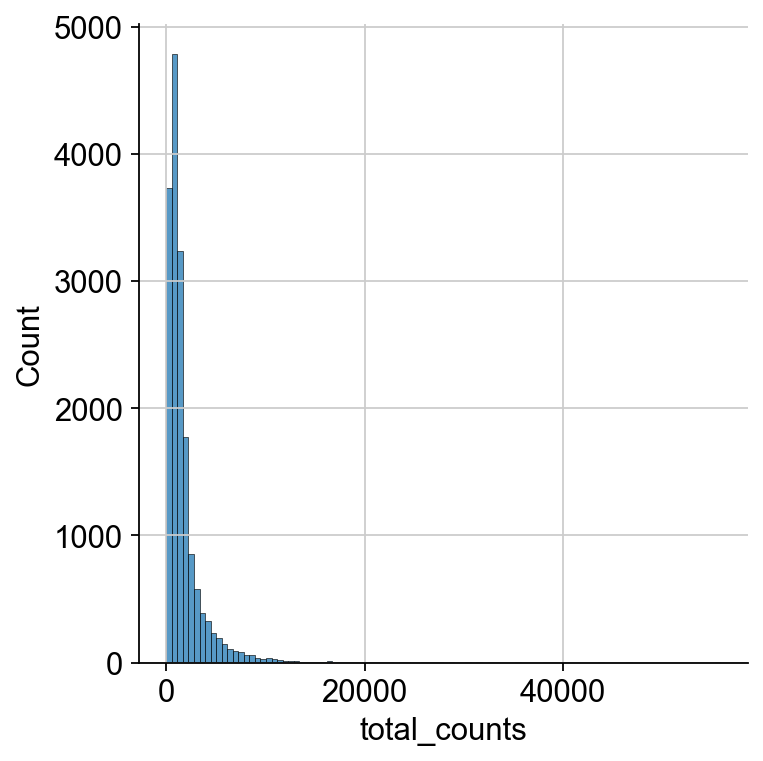

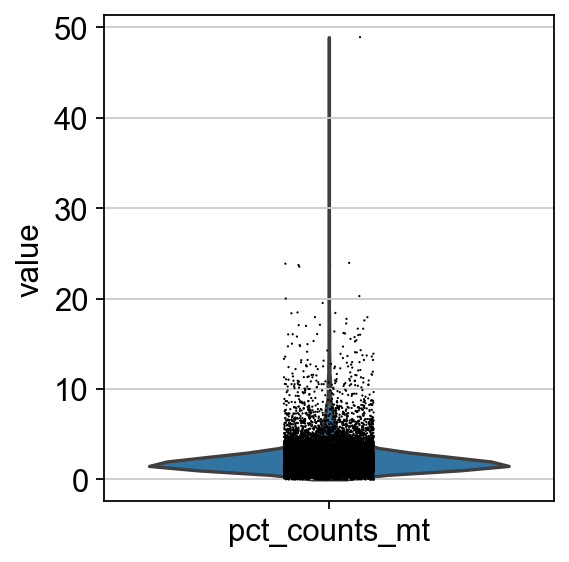

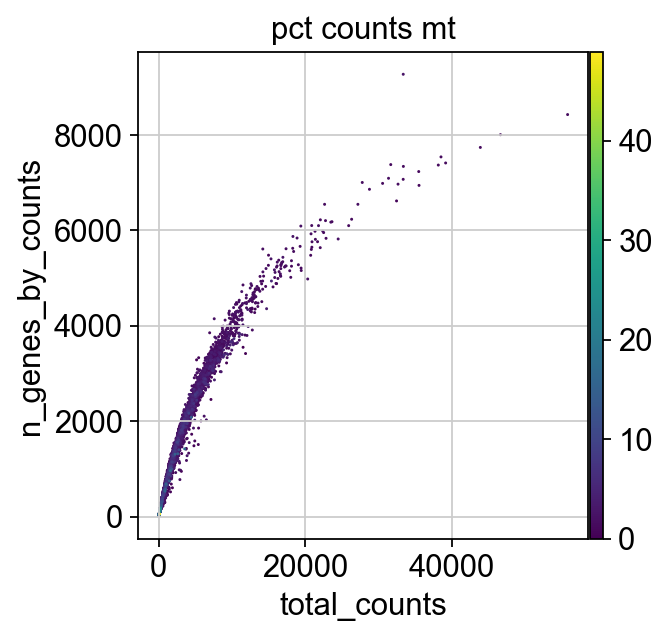

In [14]:
import seaborn as sns
p1 = sns.displot(adata.obs['total_counts'], bins=100, kde=False)
#sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, 'pct_counts_mt')
p3 = sc.pl.scatter(
    adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt'
)

The plots indicate that some reads have a relatively high percentage of mitochondrial counts which are often associated with cell degradation. But since number of counts per cell is sufficiently high and percentage of mitochondrial reads is for most cells below 20 % we can still process the data. Based on these plots, one could now also define manual thresholds for filtering cells. Instead, we will show QC with automatic thresholding and filtering based on MAD.

First, we define a function that takes a `metric`, i.e. a column in `.obs` and the number of MADs (`nmad`) that is still permissive within the filtering strategy. 

In [15]:
import numpy as np

def isOutlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * M.mad()) | (np.median(M) + nmads * M.mad() < M)
    return outlier

We now apply this function to the `log1p_total_counts`, `log1p_n_genes_by_counts` and `pct_counts_in_top_20_genes` QC covariates each with a threshold of 5 MADs.

In [16]:
adata.obs['outlier'] = isOutlier(
    adata, 'log1p_total_counts', 5
) | isOutlier(
    adata, 'log1p_n_genes_by_counts', 5
) | isOutlier(
    adata, 'pct_counts_in_top_20_genes', 5
) 
adata.obs.outlier.value_counts()

False    16512
True       422
Name: outlier, dtype: int64

`pct_counts_Mt` is filtered with 3 MADs. Additionally, cells with a percentage of mitochondrial counts exceding 8 % are filtered out.

In [17]:
adata.obs['mt_outlier'] = isOutlier(adata, 'pct_counts_mt', 3) | (adata.obs['pct_counts_mt'] > 8)
adata.obs.mt_outlier.value_counts()

False    16131
True       803
Name: mt_outlier, dtype: int64

We now filter our AnnData object based on these two additional columns. 

In [18]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 16934
Number of cells after filtering of low quality cells: 15908


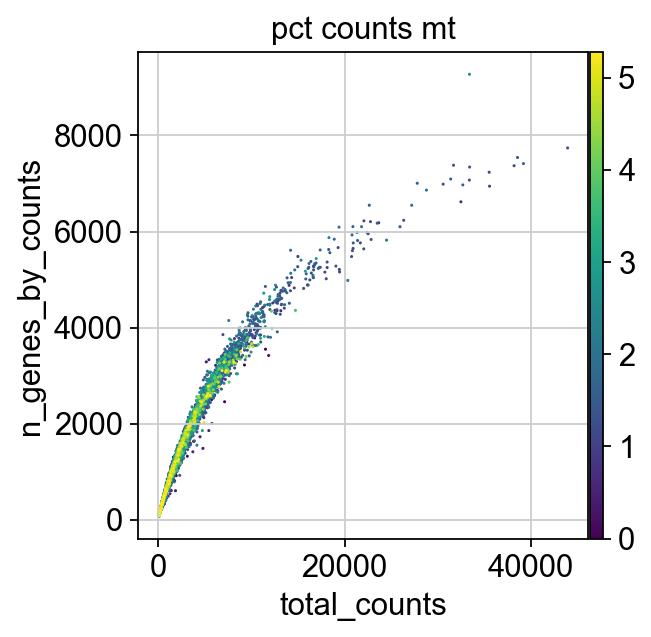

In [19]:
p1 = sc.pl.scatter(
    adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt'
)

We additionally filter out genes that are not detected in at least 20 cells as these are not informative.

In [20]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 36601
filtered out 15954 genes that are detected in less than 20 cells
Number of genes after cell filter: 20647


### Doublet Detection

Doublets are defined as two cells that are sequenced under the same cellular barcode, so for example if they were captured in the same droplet. We therefore used the term "barcode" instead if "cell" until now. A doublet is called homotypic if it is formed by the same cell type (but from different individuals) and heterotypic otherwise. Homotypic doublets are not necessarily identifiable from count matrices and are often considered innocuous as they can be identified with cell hashing or SNPs. Hence, their identification is not the main goal of the doublet detection methods. 

Doublets formed from different cell types or states are called heterotypic. Their identification is crucial as they are most likely misclassified and can lead to distorted downstream analysis steps. Hence, doublet detection and removal are typically initial preprocessing steps. Doublets can be either identified through their high number of reads and detected features, or with methods that create artificial doublets and compare these with the cells present in the dataset. Doublet detection methods are computationally efficient and there exist several software packages for this task. 

{cite}`xi_benchmarking_2021` benchmarked nine different doublet detection methods and assessed their performance with respect to computational efficiency and doublet detection accuracy. The DoubletFinder R package showed to perform best in terms of doublet detection accuracy, however performing worse with respect to computational efficiency and stability.

In this tutorial, we will showcast the DoubletFinder R package. DoubletFinder randomly selects two droplets and creates artificial doublets from those by averaging their gene expression profiles.  The doublet score is then defined as the fraction of artificial doublets in the k-nearest neighbor graph of each droplet in the principal component space. 

TODO: Add figure from doublet finder?

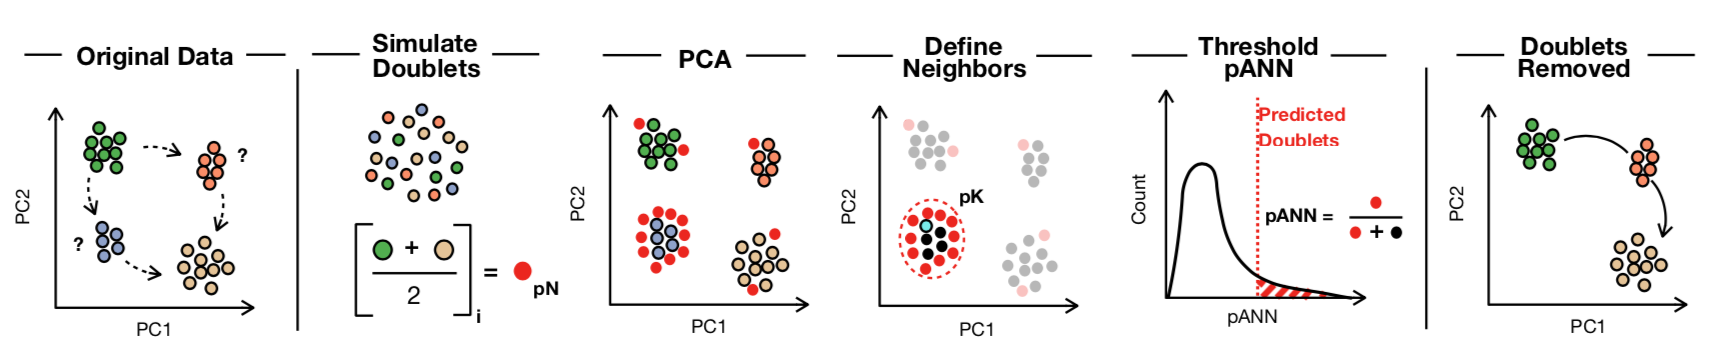

We first load some additional python and R packages.

In [21]:
%%R
library(Seurat)
library(DoubletFinder)

The dataset used here has a sparse representation of `.X`, which we have to sort in order to use it in R. 

In [22]:
if issparse(adata.X):
    if not adata.X.has_sorted_indices:
        adata.X.sort_indices()
ro.globalenv['adata'] = adata

DoubletFinder expects a fully-processed Seurat object. The method requires running NormalizeData, ScaleData, FindVariableFeatures and RunPCA. We run these methods directly on the Seurat object with default parameters as recommended by DoubletFinder. 

In [23]:
%%R -o score
doublet.seurat = as.Seurat(adata, counts="X", data = NULL)
doublet.seurat = RenameAssays(doublet.seurat, originalexp = "RNA")

## Processing of seurat object
doublet.seurat = NormalizeData(doublet.seurat)
doublet.seurat = ScaleData(doublet.seurat)
doublet.seurat = FindVariableFeatures(doublet.seurat)
doublet.seurat = RunPCA(doublet.seurat)

## Assuming 7.5% doublet formation rate - tailor for your dataset
nExp = round(0.075*nrow(doublet.seurat@meta.data))  

## Run doubletFinder v3
doublet.seurat = doubletFinder_v3(doublet.seurat, PCs = 1:10, pK = 0.09, nExp = nExp)

## Extract doubletFinder classificat
DF.name = colnames(doublet.seurat@meta.data)[grepl("DF.classification", colnames(doublet.seurat@meta.data))]
score = doublet.seurat@meta.data[[DF.name]]

[1] "Creating 5303 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."
[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


DoubletFinder outputs a score with the classification `Singlet` and `Doublet`. We add this to our AnnData object in `.obs`.

In [24]:
adata.obs['DF_score'] = score
adata.obs.DF_score.value_counts()

Singlet    14715
Doublet     1193
Name: DF_score, dtype: int64

All cells classified as doublet are now removed from the dataset. 

In [25]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[adata.obs.DF_score=='Singlet'].copy()

print(f"Number of cells after filtering of doublets: {adata.n_obs}")

Total number of cells: 15908
Number of cells after filtering of doublets: 14715



<div class="warning" style='background-color:lightgrey; color: black; border-left: solid back 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:left'>
<b>Main take-away</b></p>
<p style='margin-left:1em;'>
    
- Filtering of poor-quality cells should be based on median absolute deviations with lenient cutoffs to avoid bias against smaller subpopulations.
    
- Feature-based filtering does not show benefits for downstream tasks. 
    
- Doublets can be efficiently detected with tools like DoubletFinder. 
    
- Doublet detection methods should not be run on aggregated scRNA-seq data representing multiple batches. 
</p>
</span>
</div>

## Normalization

!ToDo update!

Up to this point, we removed doublets and low quality cells from the dataset and the data is available as a count matrix. These counts represent the capture, reverse transcription and sequencing of a molecule in the scRNA-seq experiment. Each of these steps adds a degreee of variability to the measured count depth for identical cells, so the difference in gene expression between cells in the count data might simply be due to sampling effects. The preprocessing step of "Normlaization" addresses these problems. Several normalization techniques are used in practice. One common approach is count depth scaling, i.e. counts per million (CPM) normalization. CPM normalization assumes that initally all cells in the dataset contained an equal number of molecules ad that the difference in count depth is only due to sampling. However, as datasets usually consist of heterogeneous cell populations which different cell sizes and molecule counts, more complex normalization methods are needed. 

We now introduce the reader to the normalization with *sctransform*. Sctransform was motivated by the observation that cell-to-cell variation in scRNA-seq data might be counfounded by biological heterogeneity with technical effects. The method utilizes Pearson residuals from 'regularized negative binomial regression' to calculate a model of technical noise in the data. Sctransform adds the count depth as a covariate in a generalied linear model. {cite}`germain_pipecomp_2020` showed in an independent comparision of different normalization techniques that this method removed the impact of sampling effects while preserving cell heteogeneity in the dataset. Sctransform does not require downsteam heuristic steps like pseudocount addition or log-transformation.

The output of sctransform are normalized values that can be positive or negative. Negative residuals for a cell and gene indicate that less counts are observed than expected compared to the gene's average expression and cellular sequencing depth. Positive residuals indicate the more counts respectively.  

We first load the additionally required python and R packages.

### log1p proportional fitting (log1pPF)

add citation to Depth Normalization paper

In [26]:
proportional_fitting = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers['log1pPF_normalization'] = sc.pp.log1p(proportional_fitting['X'])

normalizing counts per cell
    finished (0:00:00)


### scran normalization

add scran 

In [34]:
from scipy.sparse import csr_matrix, issparse

In [27]:
%%R
library(scran)
library(BiocParallel)

In [28]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups')

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 20 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:01)


In [29]:
import scipy
data_mat = adata_pp.X.T
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
if scipy.sparse.issparse(data_mat):
    if data_mat.nnz > 2**31-1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv['data_mat'] = data_mat
ro.globalenv['input_groups'] = adata_pp.obs['groups']

In [30]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [31]:
del adata_pp

In [35]:
adata.obs['size_factors'] = size_factors
scran = adata.X /adata.obs['size_factors'].values[:,None]
adata.layers['scran_normalization'] = csr_matrix(
    sc.pp.log1p(scran)
)

### scTransform normalization

In [36]:
%%R
library(sctransform)

The dataset used in this chapter has a sparse representation of the count matrix, so we sort the indices and add the AnnData object to the R environment.

In [37]:
if issparse(adata.X):
    if not adata.X.has_sorted_indices:
        adata.X.sort_indices()
ro.globalenv['adata'] = adata

The object is now transformed into a Seurat object with original expression annotated as "RNA" and we can call sctransform with the "glmGamPoi" method. Sctranform allows the user to only keep variable genes, we set this option to False as we are only interested in the normalization of the data. We additionally set the number of subsampling cells `ncells` to 3000 to reduce the runtime of sctransform. This number is used to build the NB regression and the default is 5000. You can adjust this number based on the compute power you have at hand.

In [38]:
%%R
seurat_obj = as.Seurat(adata, counts="X", data = NULL)
seurat_obj = RenameAssays(seurat_obj, originalexp = "RNA")
res = SCTransform(object=seurat_obj, method = "glmGamPoi", return.only.var.genes = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


Sctransform stores the result in the "SCT" assay in the Seurat object. The "SCT" assay contains the following matrices:

* `res[["SCT"]]@scale.data` stores the normalized values, the residuals, which can be used as input to PCA. This matrix is non-sparse so it is rather memory-costly for all genes. By setting the argument `return.only.var.genes` to `TURE` we can save memory and sctransform will only store variable genes. However, in this case the sctransform feature selection method is used and {cite}`germain_pipecomp_2020` recommend to use deviance as stated in the following chapter.

* sctransform additionally stored the 'corrected' UMI counts which can be interpreted as the number of counts one would observe if all cells were sequenced to the same depth. They are stored in `res[["SCT"]]@counts`.

* `res[["SCT"]]@data` contains a log-normalized version of the corrected counts. They may be helpful for visualization, differential expression analysis and integration. Generally, sctransform recommends to use the residuals directly for downstream tasks.

We now extract the residuals and save it to the AnnData object. As `sctransform` returns a gene by cell matrix, we transpose it and save it as a new layer. The residuals can then be used for further downstream analysis steps. 

In [39]:
norm_x = ro.r('res@assays$SCT@scale.data').T
adata.layers['scTransform_normalization'] = norm_x

<div class="warning" style='background-color:lightgrey; color: black; border-left: solid back 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:left'>
<b>Recommendation for selection of normalization method</b></p>
<p style='margin-left:1em;'>
    
1. Try a simply normalization technique like log1pPF and assess normlaization result by visualizing it on a UMAP with respect to total counts and highly expressed genes in your dataset.
    
2. Try scran normalization and assess if rare cell populations can be still recovered. 
    
3. If rare cell populations are removed with scran normalization, try scTransform.
</p>
</span>
</div>

## Feature selection
We now have a normalized data representation that still preserves biological heterogeneity but with reduced technical sampling effects in gene expression. So far we only removed genes that are not detected in at least 20 cells. However, in almost all cases we want to further reduce the dimensionality of the dataset and only include the most informative genes. Therefore, a standard preprocessing pipeline involves the step of feature selection which aims to exclude uninformative genes which might not represent meaningful biological variation across samples. Usually, the scRNA-seq experiment and resulting dataset focuses on one specific tissue and hence, only a small fraction of genes is informative and biologically variable. Traditional approaches and pipelines either compute the coefficient of variation (highly variable genes) or the average expression level (highly expressed genes) of 500-2000 selected genes and use these features for their downstream analysis steps. However, these methods are highly sensitive to the normalization technique used before. As mentioned earlier, a former preprocessing workflow included normalization with CPM and subsequent log transformation. But as log-transformation is not possible for exact zeros, analysts often add a small *pseudo count*, e.g., 1 (log1p), to all normalized counts before log transforming the data. Choosing the pseudo count, however, is arbitrary and can introduce biases to the transformed data. This arbitrariness has then also an effect on the feature selection as the observed variability depends on the chosen pseudo count. A small pseudo count value close to zero is increasing the variance of genes with zero counts. (CITE https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6). 

{cite}`germain_pipecomp_2020` instead proposes to use *deviance* for feature selection which works on raw counts. Deviance can be computed in closed form and quantifies whether genes show a constant expression profile across cells as these are not informative. Genes with constant expression are described by a multinomial null model, they are approximated by the binomial deviance. Highly informative genes across cells will have a high deviance value which indicates a poor fit by the null model (i.e., they don't show constant expression across cells). According to the deviance values, the method then ranks all genes and obtains only highly deviant genes. 

As mentioned before, deviance can be computed in closed form and is provided within the R package scry.


In [40]:
%%R
library(scry)

Similar to before, we save the AnnData object in our R environment. 

In [41]:
ro.globalenv['adata'] = adata

We can now directly call feature selection with deviance on the non-normalized counts matrix and export the bionomial deviance values as a vector. 

In [42]:
%%R
sce = devianceFeatureSelection(adata, assay="X")

In [43]:
binomial_deviance = ro.r('rowData(sce)$binomial_deviance').T

As a next step, we now sort the vector an select the top 4,000 highly deviant genes and save them as an additional column in `.var` as 'highly_deviant'. 

In [44]:
import numpy as np
idx = binomial_deviance.argsort()[-4000:]
msk = np.zeros(adata.var_names.shape, dtype=bool)
msk[idx] = True

adata.var['highly_deviant'] = msk

ToDo add highly variable ones?

In [45]:
sc.pp.highly_variable_genes(adata, layer='scran_normalization', flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


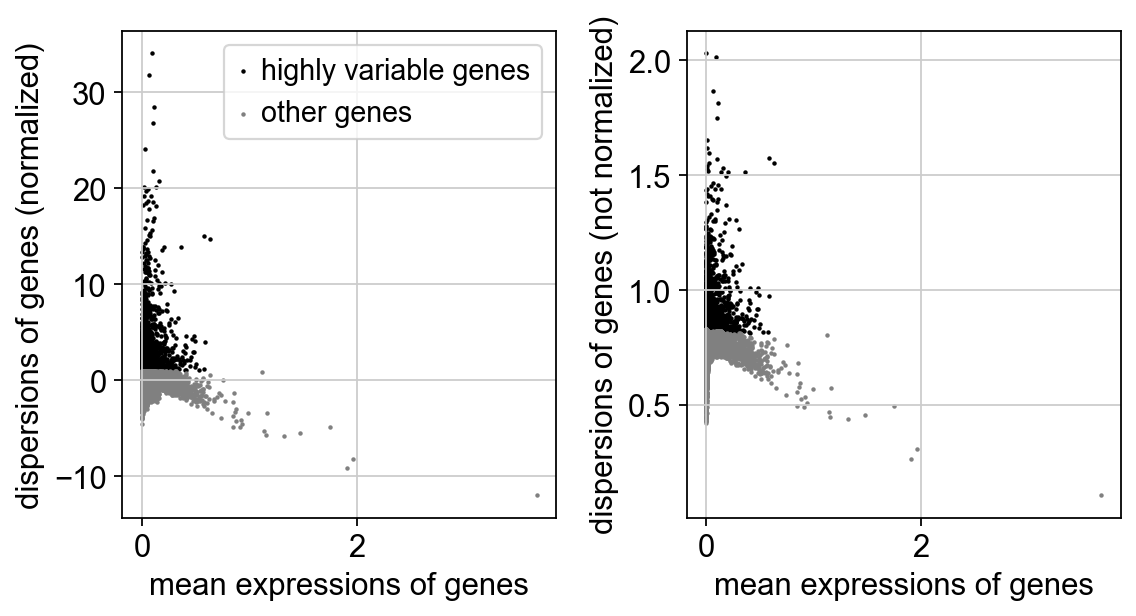

In [46]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction

As already mentioned, scRNA-seq is a high-throughput sequencing technology that produces datasets with high dimensions in the number of cells and genes. This immediatly points to the fact that scRNA-seq data suffers from the 'curse of dimensionality'. Not all genes are informative and are important for the task of cell type clustering based on their expression profiles. Therefore, an important step during preprocessing is dimensionaliy reduction which is used to reduce the data complexity and for visualization. Several dimensionality reduction techniques have been developed.

{cite}`10.3389/fgene.2021.646936` compared in an independent comparison the stability, accuracy and computing cost of 10 different dimensionality reduction methods. They propose to use t-distributed stochastic neighbor embedding (t-SNE) as it yielded the best overall performance. Uniform manifold approximation and projection (UMAP) showed the highest stability and separates best the original cell populations. An additional dimensionality reduction worth to mention in this context is principal component analysis (PCA) which is still widely used. 

All aforementioned methods are implemented in scanpy. We start with:

### PCA

In out dataset each cell is a vector of a `n_var`-dimensional vector space spanned by some orthonormal basis. As scRNA-seq suffers from the 'curse of dimensionality', we know that not all features are important to understand the underlying dynamics of the dataset and that there is an inherent redundancy. PCA creates a new set of uncorrelated variable, so called principle components (PCs), via an orthoginal transformation of the original dataset. The PCs are linear combinations of features in the original dataset and are ranked with decreasing order of variance to define the transformation. Through the ranking usually the first PC component amounts to the largest possible variance. PCs with the lowest variance are discarded to effictively reduce the dimensionality of the data without loosing information.

PCA offers the advantage that it his highly interpretable and computationally efficient. However, as scRNA-seq datasets are rather sparse due to dropout events and therefore highly non-linear, visualization with the linear dimensionality reduction technique PCA is not very appropriate. PCA is typically used to select the top 10-50 PCs which are used for downstream analysis tasks.

In [47]:
adata.layers['raw_counts'] = adata.X
adata.X = adata.layers['scran_normalization']
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


/Users/anna.schaar/opt/miniconda3/envs/bestprac2_dataprep/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'DF_score' as categorical


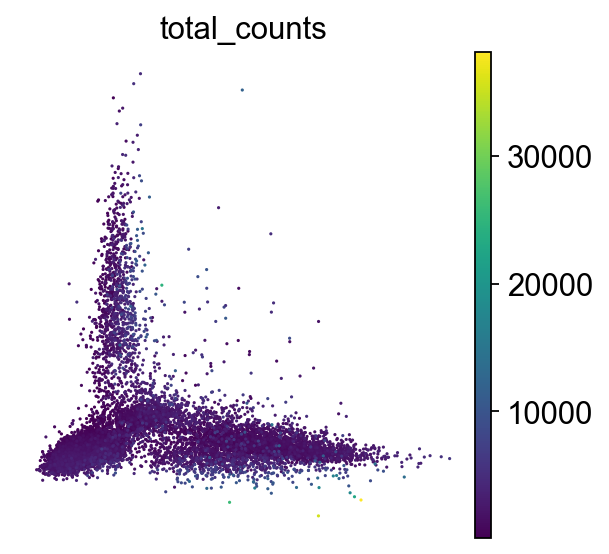

In [48]:
sc.pl.pca_scatter(adata, color='total_counts')


### t-SNE

t-SNE is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components. The method defines a Gaussian probability distribution based on the high-dimensional Euclidean distances between data points. Subsequently, a Student t-distribution is used to recreate the probability distribution in a low dimensional space where the embeddings are optimized using gradient descent.

In [49]:
sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:10)


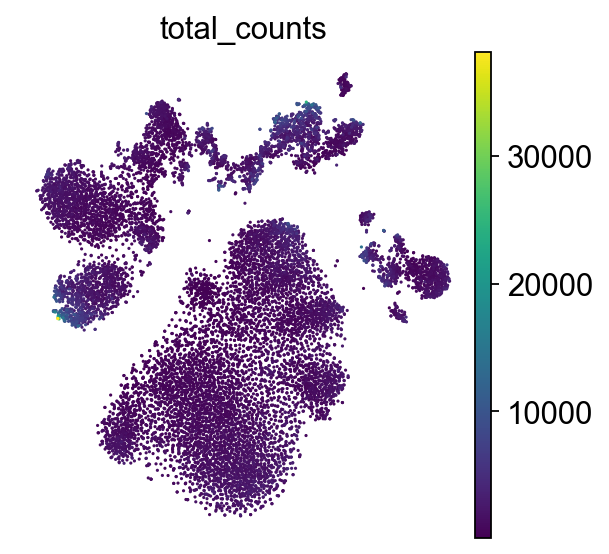

In [50]:
sc.pl.tsne(adata, color='total_counts')


### UMAP

UMAP is a graph based, non-linear dimensionality technique and principally similar to t-SNE. It constructs a high dimensional graph representation of the dataset and optimizes the low-dimensional graph representation to be structurally as similar as possible to the original graph.


We first calculate PCA and subsequently a neighborhood graph on our data.

In [51]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


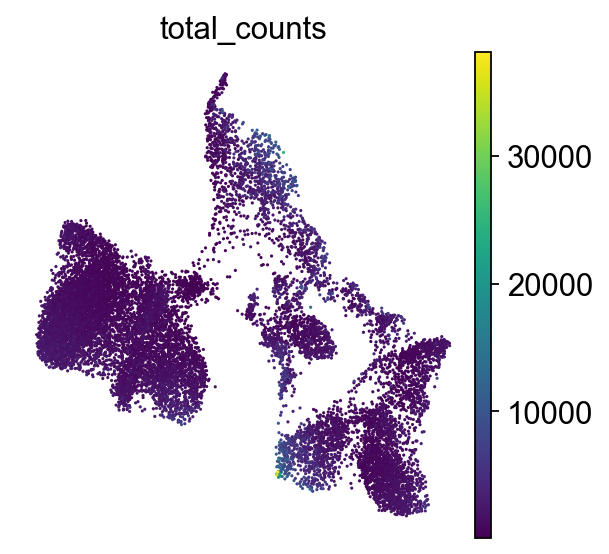

In [52]:
sc.pl.umap(adata, color='total_counts')

In [53]:
adata.write('s4d8_subset_gex.h5ad')

## References

```{bibliography}
:filter: docname in docnames
```

In [30]:
import session_info
session_info.show()